In [ ]:
!pip install datasets --upgrade
!pip install transformers
!pip install torchvision torch

In [2]:
import os
import json
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
from datasets import load_dataset

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open("/content/drive/MyDrive/ii/data.json", 'r') as f:
  data = json.load(f)

# take first 5000 element from the data
Data = data[:5000]
Data[0]

{'type': 'chair',
 'color': 'gold',
 'prompt': 'Professional product photography of a industrial gold chair, made of plywood, modular shape, featuring mesh back, conference in mind, luxury price range. Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style',
 'img_path': '/content/drive/MyDrive/Colab Notebooks/data/image_0.jpg'}

In [4]:
import torch
from PIL import Image
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel

# load the feature extraction models
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
## embedding for all images

# embedding_vector = []

# for elm in Data:
#   img = Image.open(elm["img_path"])

#   # Preprocess image for CLIP
#   input = processor(images=img, return_tensors="pt")["pixel_values"]

#   with torch.no_grad():
#     image_features = model.get_image_features(input)

#   # convert the features to unit vector
#   # cosine similarity only care about the angle between the feature vectors
#   image_features = F.normalize(image_features, dim=-1)
#   embedding_vector.append(image_features.cpu().numpy())

# embedding_vector[0]

In [ ]:
# np.save("/content/drive/MyDrive/ii/embedding_vectors.npy", embedding_vector)

In [6]:
embedding_vector = np.load("/content/drive/MyDrive/ii/embedding_vectors.npy")
embedding_vector.shape

(5000, 1, 512)

In [7]:
embedding_vector = embedding_vector.squeeze()
embedding_vector.shape

(5000, 512)

In [ ]:
!pip install qdrant-client
!pip install fastapi uvicorn

In [9]:
from google.colab import userdata

QDRANT_HOST = userdata.get('QDRANT_HOST')
QDRANT_API_KEY = userdata.get('QDRANT_API_KEY')

In [10]:
from qdrant_client import models, QdrantClient

client = QdrantClient(
    url=QDRANT_HOST,
    api_key=QDRANT_API_KEY
)

In [11]:
collection_name = "images"
client.recreate_collection(
    collection_name = collection_name,
    vectors_config=models.VectorParams(
        size=512,
        distance=models.Distance.COSINE
    ),
)

<ipython-input-11-c22b668d5990>:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [ ]:
from qdrant_client.models import PointStruct

batch_size = 500

# save data in Qdrant database
for step in range(0, len(Data), batch_size):
  points = []
  batch = Data[step:step+batch_size]

  for idx, raw in enumerate(batch):
    points.append(PointStruct(
        id = idx + step,
        vector = embedding_vector[idx + step],
        payload = {"color": raw['color']}
    ))

  client.upsert(collection_name=collection_name, points=points)

In [28]:
from qdrant_client.http.models import PayloadSchemaType

# add filter by color option
client.create_payload_index(
    collection_name=collection_name,
    field_name="color",
    field_schema=PayloadSchemaType.KEYWORD
)

UpdateResult(operation_id=11, status=<UpdateStatus.COMPLETED: 'completed'>)

In [37]:
test_data = data[20000]
test_data

{'type': 'chair',
 'color': 'beige',
 'prompt': 'Professional product photography of a side chair beige chair, made of mesh, featuring standard legs, office in mind. Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style',
 'img_path': '/content/drive/MyDrive/Colab Notebooks/data/image_20000.jpg'}

In [38]:
img = Image.open(test_data["img_path"])

input = processor(images=img, return_tensors="pt")["pixel_values"]

with torch.no_grad():
  query_image = model.get_image_features(input)

query_image = F.normalize(query_image, dim=-1)
query_image = query_image.cpu().numpy()[0]
query_image

array([-2.09854729e-03,  1.31268874e-02,  2.95770764e-02, -2.67095398e-02,
        2.85208728e-02,  1.60512701e-02,  2.83914898e-02,  6.07831590e-02,
       -3.86013053e-02,  2.88987979e-02, -9.55051219e-04,  3.43786478e-02,
        7.16229808e-03, -1.48506016e-02,  1.39917433e-02,  2.98126563e-02,
       -2.14399043e-02, -4.15882375e-03, -1.07712969e-02, -8.37270264e-03,
        6.83209375e-02, -1.94834042e-02,  2.69674938e-02,  1.23828156e-02,
        1.11968210e-02,  5.29355407e-02,  8.99641123e-03, -4.03110161e-02,
       -1.43975029e-02,  1.54252509e-02,  9.55385622e-03, -4.44357283e-04,
       -2.56764870e-02, -3.88889574e-02, -2.15776544e-02, -3.87699381e-02,
       -2.96153314e-02,  2.36567277e-02,  1.34013314e-02,  5.70995472e-02,
        8.07475578e-03, -4.75989133e-02,  7.28401449e-03,  1.02159837e-02,
        1.14986831e-02, -1.50564075e-01, -1.98893808e-02, -4.71742678e-04,
       -2.45494246e-02,  2.59394851e-02, -2.16442607e-02, -1.96425449e-02,
        6.77991137e-02, -

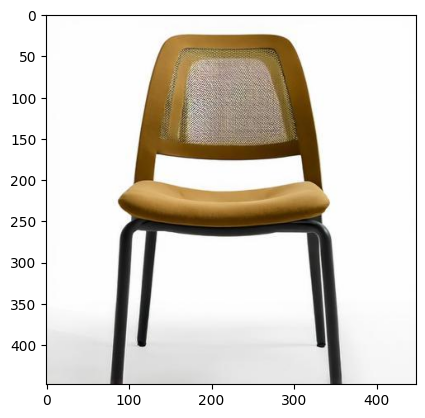

In [44]:
plt.imshow(img)
plt.show()

# Search

In [46]:
from qdrant_client.http import models

search_result = client.search(
    collection_name="images",
    query_vector=query_image,
    limit=10
)

<ipython-input-46-37d13569955b>:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


Score: 0.92209256
Color: gold


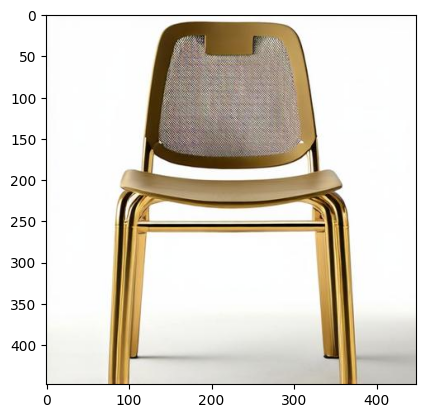

Score: 0.8985466
Color: silver


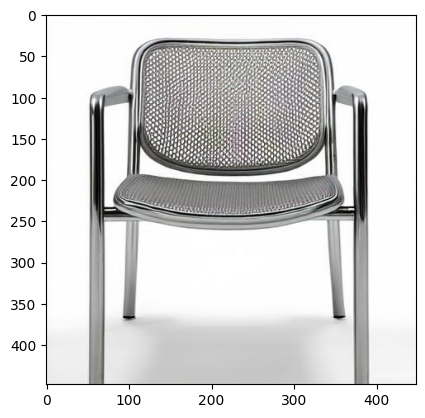

Score: 0.89582
Color: chrome


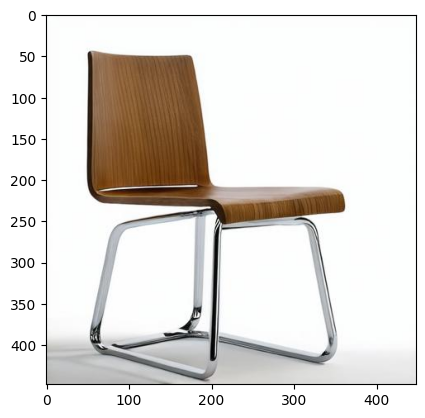

Score: 0.8946243
Color: ash


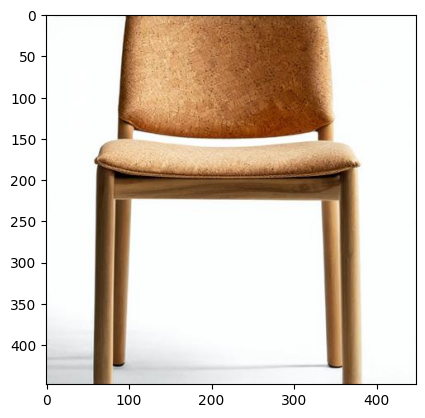

Score: 0.8941964
Color: orange


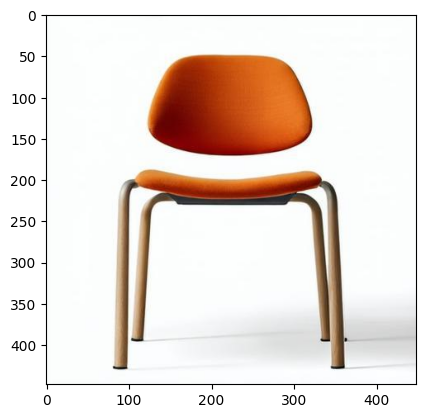

Score: 0.8933653
Color: brown


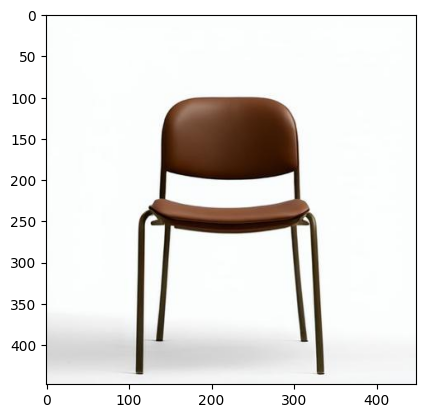

Score: 0.8930161
Color: red


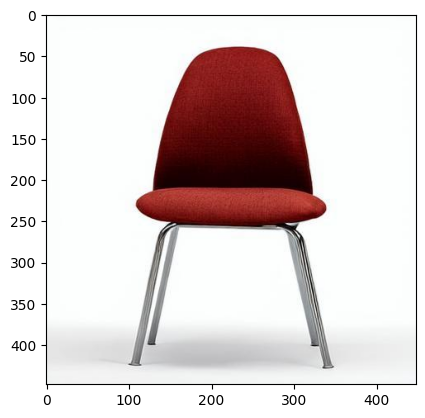

Score: 0.89294106
Color: cream


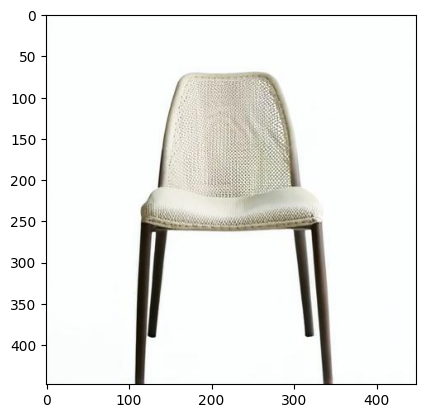

Score: 0.8928449
Color: brown


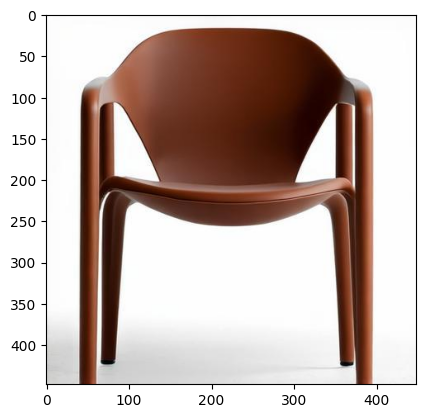

Score: 0.8921362
Color: gold


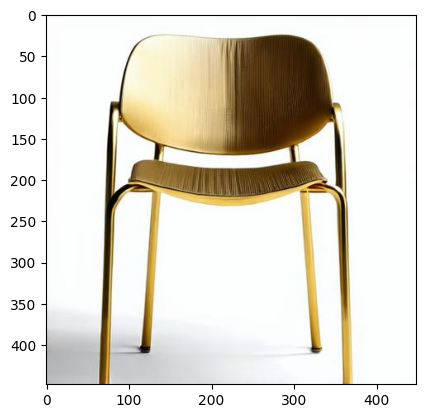

In [47]:
for hit in search_result:
  print("Score:", hit.score)
  print("Color:", hit.payload["color"])
  curr_img = Image.open(Data[hit.id]["img_path"])
  plt.imshow(curr_img)
  plt.show()

# Color filter Search

In [48]:
from qdrant_client.http import models

search_result = client.search(
    collection_name="images",
    query_vector=query_image,
    limit=10,
    query_filter=models.Filter(
        must=[
            models.FieldCondition(
                key="color",
                match=models.MatchValue(value="gray")
            )
        ]
    )
)

<ipython-input-48-b8cb074551d4>:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


Score: 0.8918874
Color: gray


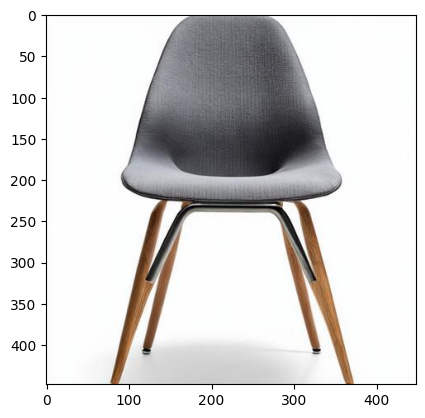

Score: 0.883361
Color: gray


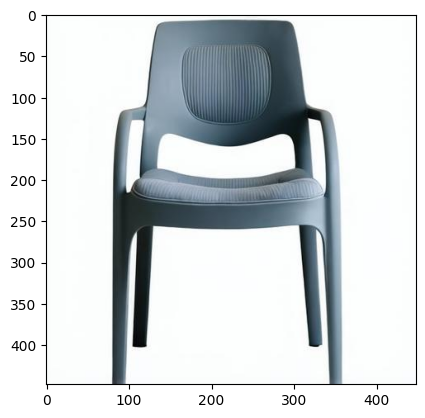

Score: 0.8817259
Color: gray


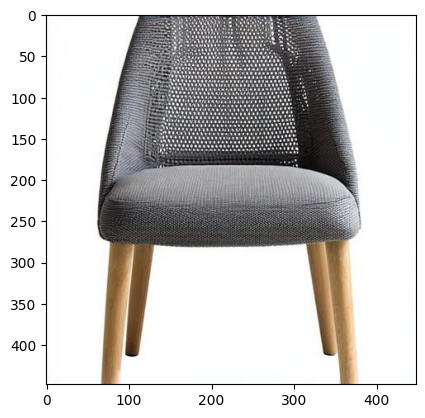

Score: 0.8794601
Color: gray


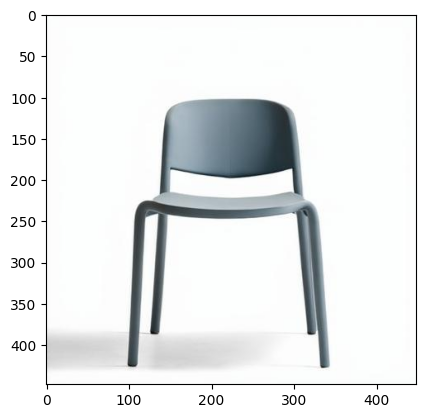

Score: 0.8788599
Color: gray


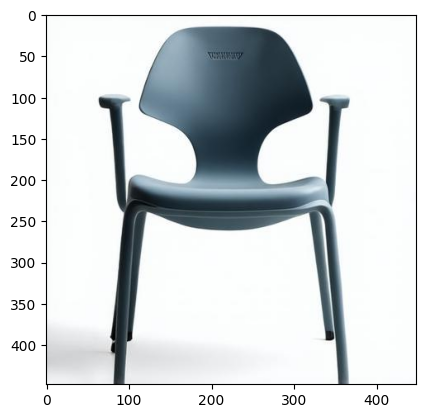

Score: 0.871287
Color: gray


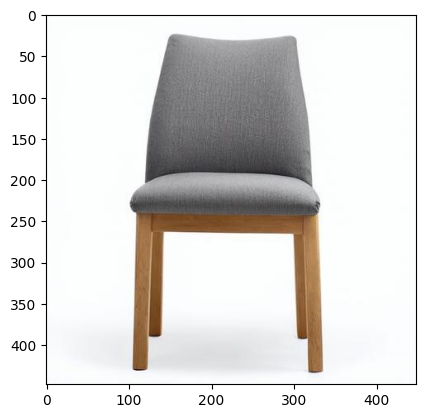

Score: 0.8712582
Color: gray


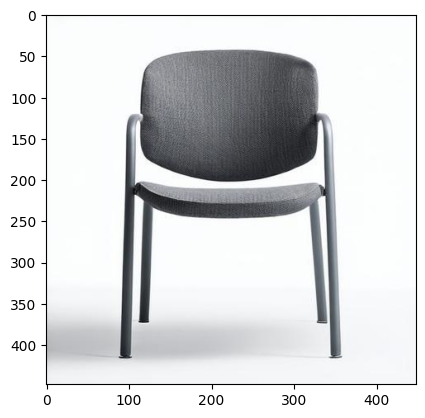

Score: 0.8701582
Color: gray


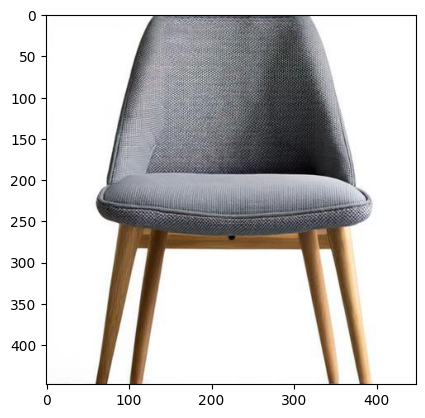

Score: 0.870111
Color: gray


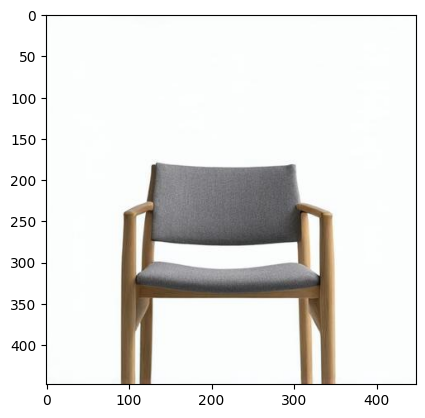

Score: 0.8688822
Color: gray


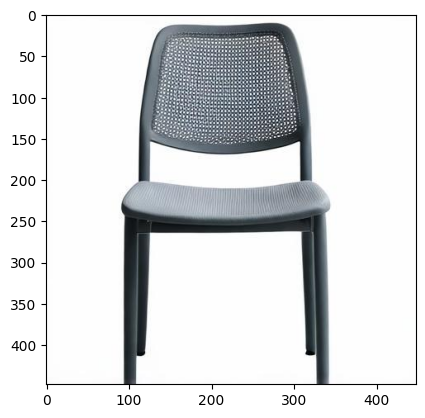

In [49]:
for hit in search_result:
  print("Score:", hit.score)
  print("Color:", hit.payload["color"])
  curr_img = Image.open(Data[hit.id]["img_path"])
  plt.imshow(curr_img)
  plt.show()